# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import Lasso
from lightgbm import LGBMRegressor
from pandas_profiling import ProfileReport
import plotly.express as px
from category_encoders.binary import BinaryEncoder
from sklearn.model_selection import GridSearchCV

/tmp/ipykernel_269/55663167.py:17: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


In [5]:
try:
    df = pd.read_csv('/datasets/autos.csv')
except:
    df = pd.read_csv('/Users/v.rakhaev/Desktop/Yandex/sprint_14/autos.csv')

In [6]:
df.head(3)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46


In [7]:
#profile = ProfileReport(df, title="Pandas Profiling Report")

In [8]:
#profile

In [9]:
df.shape

(354369, 16)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

**Поиск уникальных значений**

In [11]:
for i in df:
    print('Признак - ', i)
    print('Количество уникальных значений', len(df.loc[:,i].unique()))
    print()
    print(df.loc[:,i].unique())
    print('-------------------------------------------')

Признак -  DateCrawled
Количество уникальных значений 271174

['2016-03-24 11:52:17' '2016-03-24 10:58:45' '2016-03-14 12:52:21' ...
 '2016-03-21 09:50:58' '2016-03-14 17:48:27' '2016-03-19 18:57:12']
-------------------------------------------
Признак -  Price
Количество уникальных значений 3731

[  480 18300  9800 ... 12395 18429 10985]
-------------------------------------------
Признак -  VehicleType
Количество уникальных значений 9

[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
-------------------------------------------
Признак -  RegistrationYear
Количество уникальных значений 151

[1993 2011 2004 2001 2008 1995 1980 2014 1998 2005 1910 2016 2007 2009
 2002 2018 1997 1990 2017 1981 2003 1994 1991 1984 2006 1999 2012 2010
 2000 1992 2013 1996 1985 1989 2015 1982 1976 1983 1973 1111 1969 1971
 1987 1986 1988 1970 1965 1945 1925 1974 1979 1955 1978 1972 1968 1977
 1961 1960 1966 1975 1963 1964 5000 1954 1958 1967 1959 9999 1956 3200
 1000 1941 8888 1500 22

### Пропуски

In [12]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

**Присутствуют неадекватные значения годов в признаке 'RegistrationYear'**

In [13]:
df['RegistrationYear'].value_counts().sort_index().head()

1000    37
1001     1
1039     1
1111     3
1200     1
Name: RegistrationYear, dtype: int64

**Удалим значения до 1980г и после 2015г**

In [14]:
df.drop(df.query('RegistrationYear > 2015').index, inplace = True)
df.drop(df.query('RegistrationYear < 1980').index, inplace = True)

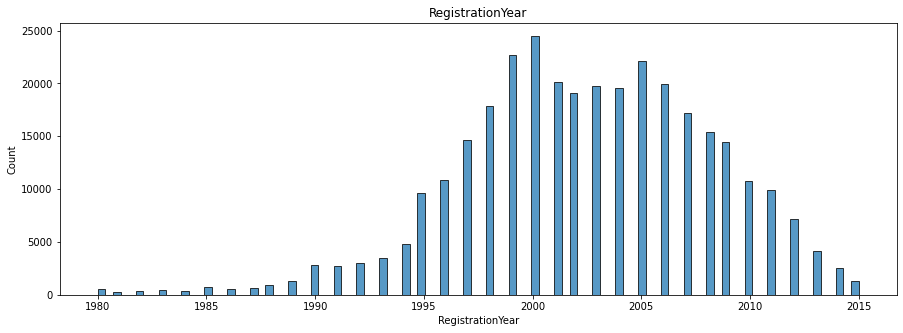

In [15]:
plt.figure(figsize=(15,5))
sns.histplot(df['RegistrationYear'], bins = 100)
plt.title('RegistrationYear')
plt.show()

**Присутствуют неадекватные значения в признаке 'Power'**

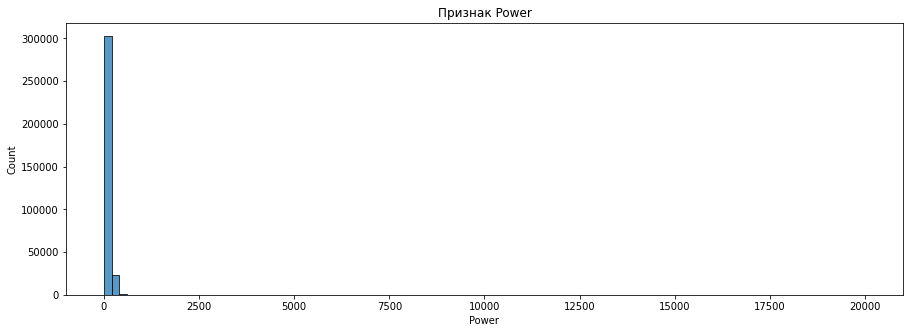

In [16]:
plt.figure(figsize=(15,5))
sns.histplot(df['Power'], bins = 100)
plt.title('Признак Power')
plt.show()

**удалим значения == 0**

In [17]:
df.drop(df.query('Power == 0').index, inplace = True)

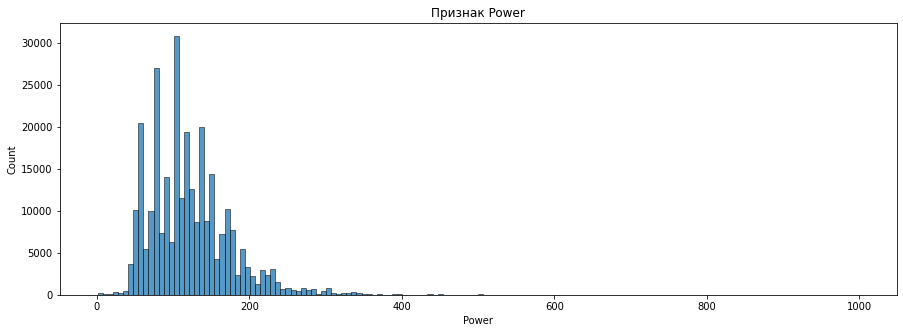

In [18]:
plt.figure(figsize=(15,5))
sns.histplot(df['Power'][df['Power'] < 1000], bins = 150)
plt.title('Признак Power')
plt.show()

**удалим значения > 350 и < 50**

In [19]:
df.drop(df.query('Power > 350').index, inplace = True)
df.drop(df.query('Power < 50').index, inplace = True)

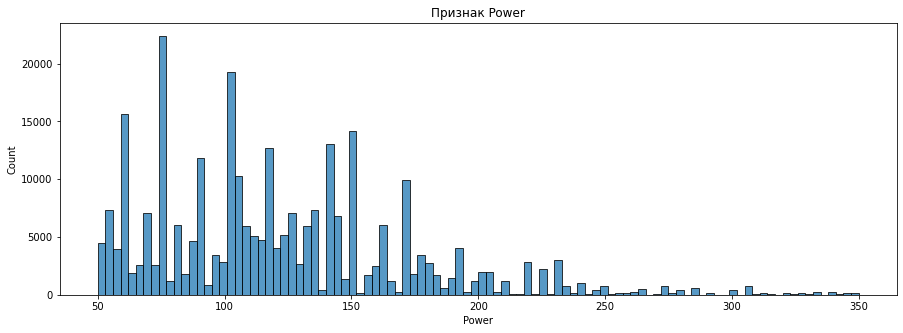

In [20]:
plt.figure(figsize=(15,5))
sns.histplot(df['Power'], bins = 100)
plt.title('Признак Power')
plt.show()

**Заполним значение признака 'Model' как "unknown"**

In [21]:
df['Model'].fillna("unknown", inplace = True)

**Заполним значение признака 'VehicleType'**

In [22]:
df['VehicleType'].value_counts()

sedan          83266
small          67303
wagon          60110
bus            26361
convertible    18453
coupe          14294
suv            10846
other           2406
Name: VehicleType, dtype: int64

Алгоритм заполнения:  
1. Сначала заполним пропущенные значения признака 'VehicleType' как null
2. Далее создадим функцию которая заменят null значения в признаке 'VehicleType' самым популярным из показателя признака 'Model', например, если условно среди audi самое популярный тип кузова - sedan, то пропущенные значения в audi будут заполнены как sedan.

In [23]:
df['VehicleType'].fillna('null', inplace = True)

In [24]:
def brand_VehicleType(x):
    if x['VehicleType'] == 'null':
        return df[df['Brand'] == x['Brand']]['VehicleType'].value_counts().index[0]
    else:
        return x['VehicleType']

In [25]:
%%time
df['VehicleType'] = df[['Brand','VehicleType']].apply(brand_VehicleType, axis = 1)


CPU times: user 2min 19s, sys: 23.7 ms, total: 2min 19s
Wall time: 2min 19s


In [26]:
df['VehicleType'].value_counts()

sedan          85798
small          69318
wagon          60609
bus            26380
convertible    18462
coupe          14294
suv            10910
other           2406
Name: VehicleType, dtype: int64

**Заполним значение признака 'FuelType'**

аналогично 'VehicleType'

In [27]:
df['FuelType'].value_counts()

petrol      182195
gasoline     87269
lpg           4670
cng            478
hybrid         197
other           54
electric        32
Name: FuelType, dtype: int64

In [28]:
df['FuelType'].fillna('null', inplace = True)

In [29]:
def brand_FuelType(x):
    if x['FuelType'] == 'null':
        return df[df['Brand'] == x['Brand']]['FuelType'].value_counts().index[0]
    else:
        return x['FuelType']

In [30]:
%%time
df['FuelType'] = df[['Brand','FuelType']].apply(brand_FuelType, axis = 1)

CPU times: user 5min 44s, sys: 127 ms, total: 5min 44s
Wall time: 5min 45s


In [31]:
df['FuelType'].value_counts()

petrol      195467
gasoline     87279
lpg           4670
cng            478
hybrid         197
other           54
electric        32
Name: FuelType, dtype: int64

**Заполним значение признака 'Gearbox'**

In [32]:
df['Gearbox'].value_counts()

manual    226124
auto       57280
Name: Gearbox, dtype: int64

**Заполним пропуски как 'unknown'**

In [33]:
df['Gearbox'].fillna('unknown', inplace = True)

In [34]:
df['Gearbox'].value_counts()

manual     226124
auto        57280
unknown      4773
Name: Gearbox, dtype: int64

**Заполним значение признака 'Repaired'**

In [35]:
df['Repaired'].value_counts()

no     219134
yes     28407
Name: Repaired, dtype: int64

Заполним пропуски как 'unknown'

In [36]:
df['Repaired'].fillna('unknown', inplace = True)

In [37]:
df['Repaired'].value_counts()

no         219134
unknown     40636
yes         28407
Name: Repaired, dtype: int64

In [38]:
df['FuelType'] = df['FuelType'].replace('gasoline', 'petrol')

In [39]:
df['FuelType'].value_counts()

petrol      282746
lpg           4670
cng            478
hybrid         197
other           54
electric        32
Name: FuelType, dtype: int64

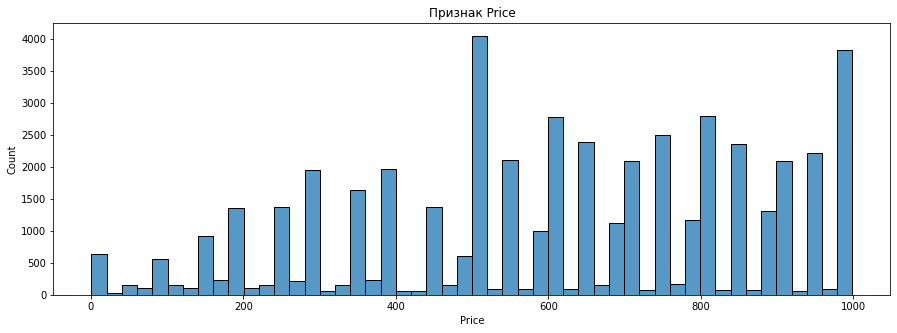

In [40]:
plt.figure(figsize = (15,5))
plt.title('Признак Price')
sns.histplot(df.query('0 < Price < 1000'), x = 'Price', bins = 50)
plt.show()

In [41]:
df['Price'].value_counts()

0        5723
1500     4237
500      4024
1200     3563
2500     3560
         ... 
6966        1
11687       1
13220       1
4919        1
8188        1
Name: Price, Length: 3543, dtype: int64

**В целевом признаке 'Price' присутствуют экстримально низкие значения значения удалим их**

In [42]:
df.drop(df.query('Price < 101').index, inplace = True)

### Изменение форматов признаков

In [43]:
df['LastSeen'] = pd.to_datetime(df['LastSeen'])

In [44]:
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'])

In [45]:
df['DateCreated'] = pd.to_datetime(df['DateCreated'])

### Дубликаты

In [46]:
df.duplicated().sum()

4

In [47]:
df.drop_duplicates(inplace=True)

### Выводы по первому блоку:
1. Проведен анализ данных
2. Определены и устранены экстримальные значения признаков
3. Удалены явные дубликаты
4. Полстроена функция для 'нетипового' заолнения данных
5. Данные подготовлены для построения моделей

## Данные для построения модели

Выберем неоходимые признаки для построения модели

In [48]:
df_model = df[['VehicleType', 'Gearbox', 'Power', 'Kilometer', 'FuelType', 'Brand', 'Repaired', 'RegistrationYear', 'Model','Price']]

In [49]:
df_model.reset_index(drop=True, inplace = True)

In [50]:
df_model.isna().sum()

VehicleType         0
Gearbox             0
Power               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
RegistrationYear    0
Model               0
Price               0
dtype: int64

In [51]:
df_model_change = df_model.copy()

In [52]:
df_model_change_feature = df_model_change.drop('Price', axis = 1)

In [53]:
df_model_change_target = df_model_change['Price']

Разобьем данные на тренировочные и тестовые и валидационные

In [54]:
features_train, features_test_plus_valid, target_train, target_test_plus_valid = train_test_split(
    df_model_change_feature, df_model_change_target, test_size=0.4, random_state=54321)

In [55]:
features_test, features_valid, target_test, target_valid = train_test_split(
    features_test_plus_valid, target_test_plus_valid, test_size=0.5, random_state=543211)

In [56]:
display(features_train.shape)
display(features_test.shape)
display(features_valid.shape)
display(target_train.shape)
display(target_test.shape)
display(target_valid.shape)

(168585, 9)

(56195, 9)

(56196, 9)

(168585,)

(56195,)

(56196,)

Проведем кодирование - переведем текстовые значения в цифровые

In [57]:
bn = BinaryEncoder()
bn.fit(features_train)
features_train_bn = bn.transform(features_train)
features_test_bn = bn.transform(features_test)
features_valid_bn = bn.transform(features_valid)


Мультиколлинеарность не выявлена

## Обучение моделей

In [64]:
scaler = StandardScaler()
scaler.fit(features_train_bn)
features_train_bn_scaled = pd.DataFrame(scaler.transform(features_train_bn), columns = features_train_bn.columns)
features_test_bn_scaled = pd.DataFrame(scaler.transform(features_test_bn), columns = features_test_bn.columns)
features_valid_bn_scaled = pd.DataFrame(scaler.transform(features_valid_bn), columns = features_valid_bn.columns)

**LinearRegression**

**LinearRegression и кросс - валидация**

In [64]:
%%time
model = LinearRegression()
MSE = cross_val_score(model, features_train_bn_scaled, target_train,
                              cv=5,scoring='neg_mean_squared_error') * -1
print('MSE=', MSE)
print('--------------------------------------------------------')
print('MSE mean =', round(MSE.mean(),2))
print('--------------------------------------------------------')
print('RMSE mean =', round(MSE.mean()**0.5,2))
print('--------------------------------------------------------')

MSE= [6948223.97024901 7062982.59503029 7034683.4398587  7134629.7055783
 6893324.75787614]
--------------------------------------------------------
MSE mean = 7014768.89
--------------------------------------------------------
RMSE mean = 2648.54
--------------------------------------------------------
CPU times: user 1.8 s, sys: 1.62 s, total: 3.41 s
Wall time: 3.61 s


**DecisionTreeRegressor**

**Подберем оптимальные гиперпараметры**

In [65]:
%%time
best_MSE = 10000000000000
best_model = None
for depth in range(1,20):
    model = DecisionTreeRegressor(random_state=12345, max_depth = depth)
    MSE = cross_val_score(model, features_train_bn_scaled, target_train, cv=5, scoring='neg_mean_squared_error')
    MSE = (-MSE.mean())
    if MSE < best_MSE:
        best_MSE = MSE
        best_model = model    
print('best_MSE =', round(best_MSE,2))
print('--------------------------------------------------------')
print('best_RMSE =', round(best_MSE**0.5,2))
print('--------------------------------------------------------')
print('best_Model =', best_model)


best_MSE = 3568435.92
--------------------------------------------------------
best_RMSE = 1889.03
--------------------------------------------------------
best_Model = DecisionTreeRegressor(max_depth=13, random_state=12345)
CPU times: user 56.1 s, sys: 357 ms, total: 56.5 s
Wall time: 57.6 s


**CatBoostRegressor**

In [66]:
param_grid_01 = {'learning_rate' : np.arange(0.1, 0.5, 0.1)}

In [67]:
%%time
model = CatBoostRegressor(random_state=12345, verbose=False)

tuning_model=GridSearchCV(estimator=model,
                          param_grid=param_grid_01,
                          scoring='neg_root_mean_squared_error',
                          cv=5,
                          verbose=5)

tuning_model.fit(features_train_bn_scaled, target_train)
display(tuning_model.best_params_)
display(tuning_model.best_score_*-1)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ..............................learning_rate=0.1; total time=  30.7s
[CV 2/5] END ..............................learning_rate=0.1; total time=  30.4s
[CV 3/5] END ..............................learning_rate=0.1; total time=  29.6s
[CV 4/5] END ..............................learning_rate=0.1; total time=  29.5s
[CV 5/5] END ..............................learning_rate=0.1; total time=  32.4s
[CV 1/5] END ..............................learning_rate=0.2; total time=  32.2s
[CV 2/5] END ..............................learning_rate=0.2; total time=  30.2s
[CV 3/5] END ..............................learning_rate=0.2; total time=  30.6s
[CV 4/5] END ..............................learning_rate=0.2; total time=  31.5s
[CV 5/5] END ..............................learning_rate=0.2; total time=  32.3s
[CV 1/5] END ..............learning_rate=0.30000000000000004; total time=  27.9s
[CV 2/5] END ..............learning_rate=0.300000

{'learning_rate': 0.30000000000000004}

1528.6458278174564

CPU times: user 8min 55s, sys: 3.43 s, total: 8min 59s
Wall time: 10min 14s


**Lasso**

In [68]:
%%time
best_MSE = 10000000000000
best_model = None
for alp in np.arange(0.1, 1.01, 0.1):
    model = Lasso(alpha=alp, max_iter=2500, random_state=12345)
    MSE = cross_val_score(model, features_train_bn_scaled, target_train, cv=5, scoring='neg_mean_squared_error')
    MSE = (-MSE.mean())
    if MSE < best_MSE:
        best_MSE = MSE
        best_model = model    
print('best_MSE =', round(best_MSE,2))
print('--------------------------------------------------------')
print('best_RMSE =', round(best_MSE**0.5,2))
print('--------------------------------------------------------')
print('best_Model =', best_model)


best_MSE = 7014769.54
--------------------------------------------------------
best_RMSE = 2648.54
--------------------------------------------------------
best_Model = Lasso(alpha=0.1, max_iter=2500, random_state=12345)
CPU times: user 14min 26s, sys: 23min 7s, total: 37min 33s
Wall time: 37min 38s


**LGBMRegressor**

In [94]:
param_grid_02 = {'n_estimators': [40], 'num_leaves': [6, 10, 18]}

In [95]:
%%time
model = LGBMRegressor(random_state=12345, extra_trees = True)

tuning_model=GridSearchCV(estimator=model,
                          param_grid=param_grid_02,
                          scoring='neg_root_mean_squared_error',
                          cv=3,
                          verbose=3)

tuning_model.fit(features_train_bn_scaled, target_train)
display(tuning_model.best_params_)
display(tuning_model.best_score_*-1)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3] END ..................n_estimators=40, num_leaves=6; total time=  25.9s
[CV 2/3] END ..................n_estimators=40, num_leaves=6; total time=  33.5s
[CV 3/3] END ..................n_estimators=40, num_leaves=6; total time=  22.4s
[CV 1/3] END .................n_estimators=40, num_leaves=10; total time=  38.1s
[CV 2/3] END .................n_estimators=40, num_leaves=10; total time=  41.2s
[CV 3/3] END .................n_estimators=40, num_leaves=10; total time=  34.5s
[CV 1/3] END .................n_estimators=40, num_leaves=18; total time=  48.4s
[CV 2/3] END .................n_estimators=40, num_leaves=18; total time= 1.6min
[CV 3/3] END .................n_estimators=40, num_leaves=18; total time=  54.7s


{'n_estimators': 40, 'num_leaves': 18}

1938.7285337250378

CPU times: user 8min 11s, sys: 8.53 s, total: 8min 19s
Wall time: 8min 23s


## Анализ моделей

**Проверка скорости работы моделей на тренировочной выборке**

**Lasso**

In [96]:
%%time
model = Lasso(alpha=0.1, max_iter=2500, random_state=12345)
model.fit(features_train_bn_scaled, target_train)

CPU times: user 7.51 s, sys: 12.8 s, total: 20.4 s
Wall time: 20.3 s


Lasso(alpha=0.1, max_iter=2500, random_state=12345)

In [97]:
%%time
prediction = model.predict(features_train_bn_scaled)

CPU times: user 20.3 ms, sys: 28.2 ms, total: 48.6 ms
Wall time: 29.1 ms


**LinearRegression**

In [98]:
%%time
model = LinearRegression()
model.fit(features_train_bn_scaled, target_train)

CPU times: user 246 ms, sys: 213 ms, total: 459 ms
Wall time: 452 ms


LinearRegression()

In [99]:
%%time
prediction = model.predict(features_train_bn_scaled)

CPU times: user 34.4 ms, sys: 32.9 ms, total: 67.3 ms
Wall time: 22.6 ms


**DecisionTreeRegressor**

In [100]:
%%time
model = DecisionTreeRegressor(max_depth=13, random_state=12345)
model.fit(features_train_bn_scaled, target_train)


CPU times: user 803 ms, sys: 509 µs, total: 804 ms
Wall time: 815 ms


DecisionTreeRegressor(max_depth=13, random_state=12345)

In [101]:
%%time
prediction = model.predict(features_train_bn_scaled)


CPU times: user 43.3 ms, sys: 0 ns, total: 43.3 ms
Wall time: 41.3 ms


**CatBoostRegressor**

In [104]:
%%time
model = CatBoostRegressor(learning_rate= 0.3, iterations = 200,random_state=1122334455, verbose=False)
model.fit(features_train_bn, target_train)

CPU times: user 6.01 s, sys: 0 ns, total: 6.01 s
Wall time: 7.31 s


In [105]:
%%time
prediction = model.predict(features_train_bn)


CPU times: user 65.2 ms, sys: 0 ns, total: 65.2 ms
Wall time: 74.9 ms


**LGBMRegressor**

In [121]:
%%time
model = LGBMRegressor(random_state=11223344, num_leaves=18, n_estimators=40, extra_trees = True) 
model.fit(features_train_bn_scaled, target_train)


CPU times: user 1min, sys: 905 ms, total: 1min 1s
Wall time: 1min 2s


LGBMRegressor(extra_trees=True, n_estimators=40, num_leaves=18,
              random_state=11223344)

In [122]:
%%time
prediction = model.predict(features_train_bn_scaled)


CPU times: user 575 ms, sys: 0 ns, total: 575 ms
Wall time: 570 ms


### Определим лучшее значение RMSE каждой из метрик на валидационной выборке

**LinearRegression**

In [107]:
%%time
model = LinearRegression()
model.fit(features_train_bn_scaled, target_train)
prediction = model.predict(features_valid_bn_scaled)
MSE = mean_squared_error(target_valid,prediction)
print('RMSE =', MSE**0.5)

RMSE = 2650.276085007207
CPU times: user 330 ms, sys: 259 ms, total: 590 ms
Wall time: 521 ms


**Lasso**

In [112]:
%%time
model = Lasso(alpha=0.1, max_iter=2500, random_state=12345)
model.fit(features_train_bn_scaled, target_train)
prediction = model_2.predict(features_valid_bn_scaled)
MSE = mean_squared_error(target_valid,prediction)
print('RMSE =', MSE**0.5)

RMSE = 2650.2767690539013
CPU times: user 4.37 s, sys: 6.63 s, total: 11 s
Wall time: 10.9 s


**DecisionTreeRegressor**

In [113]:
%%time
model = DecisionTreeRegressor(max_depth=13, random_state=12345)
model.fit(features_train_bn_scaled, target_train)
prediction = model.predict(features_valid_bn_scaled)
MSE = mean_squared_error(target_valid,prediction)
print('RMSE =', MSE**0.5)

RMSE = 1841.522065657301
CPU times: user 841 ms, sys: 0 ns, total: 841 ms
Wall time: 863 ms


**CatBoostRegressor**

In [114]:
%%time
model = CatBoostRegressor(learning_rate= 0.3, iterations = 200,random_state=1122334455, verbose=False)
model.fit(features_train_bn_scaled, target_train)
prediction = model.predict(features_valid_bn_scaled)
MSE = mean_squared_error(target_valid,prediction)
print('RMSE =', MSE**0.5)

RMSE = 1573.5645694738698
CPU times: user 5.79 s, sys: 17.1 ms, total: 5.8 s
Wall time: 6.86 s


**LGBMRegressor**

In [115]:
%%time
model = LGBMRegressor(random_state=11223344, num_leaves=18, n_estimators=40, extra_trees = True) 
model.fit(features_train_bn_scaled, target_train)
prediction = model.predict(features_valid_bn_scaled)
MSE = mean_squared_error(target_valid,prediction)
print('RMSE =', MSE**0.5)

RMSE = 1920.901796647258
CPU times: user 1min 13s, sys: 1.28 s, total: 1min 14s
Wall time: 1min 14s


In [127]:
pd.DataFrame({'Lasso' : ['20.3 s', '29.1 ms', '2650.27'],
             'LinearRegression' : ['252 ms', '22.6 ms', '2650.27'],
              'DecisionTreeRegressor' : ['815 ms', '41.3 ms', '1841.52'],
              'CatBoostRegressor' : ['7.31 s', '74.9 ms', '1573.57'],
              'LGBMRegressor' : ['1 min 2s', '570 ms', '1920.90']
             
             
             
             }, index = ['Fit','Predict','RMSE'])

,Lasso,LinearRegression,DecisionTreeRegressor,CatBoostRegressor,LGBMRegressor
Fit,20.3 s,252 ms,815 ms,7.31 s,1 min 2s
Predict,29.1 ms,22.6 ms,41.3 ms,74.9 ms,570 ms
RMSE,2650.27,2650.27,1841.52,1573.57,1920.90


**По условиям задания значение метрики RMSE должно быть меньше 2500, после прогонки на кросс-валидации тренировочных данных подошли след модели и их гипперпараметры:**
- DecisionTreeRegressor(max_depth=13, random_state=12345), RMSE = 1841.52 
- CatBoostRegressor(learning_rate= 0.3, iterations = 200,random_state=1122334455, verbose=False), RMSE = 1573.57
- LGBMRegressor(random_state=11223344, num_leaves=18, n_estimators=40, extra_trees = True) RMSE = 1920.90 

Прогоним тестовые данные для определения лучшей модели

Среди 3ех лидеров, по качеству RMSE (валидационная выборка) занимает модель CatBoostRegressor. Прогоним ее на тестовой выборке

In [65]:
%%time
model = CatBoostRegressor(learning_rate= 0.5, iterations = 200,random_state=1122334455, verbose=False)
model.fit(features_train_bn_scaled, target_train)
prediction = model.predict(features_test_bn_scaled)
MSE = mean_squared_error(target_test,prediction)
print('RMSE =', MSE**0.5)

RMSE = 1574.245871163588
CPU times: user 4.5 s, sys: 87.9 ms, total: 4.58 s
Wall time: 6.99 s


In [102]:
a = prediction[:100]
b = np.array(target_test[:100])

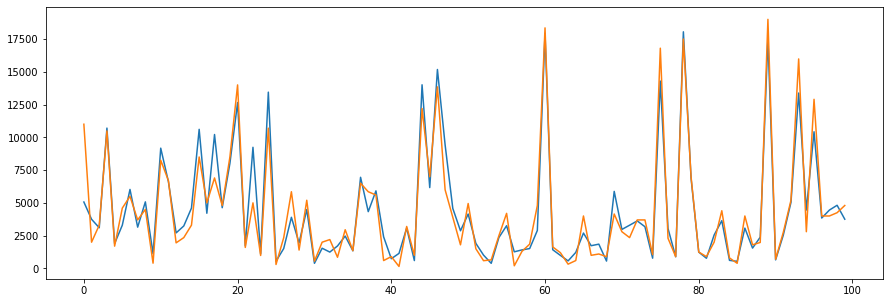

In [105]:
plt.figure(figsize = (15,5))
plt.plot(a)
plt.plot(b)


## Общие выводы:
Были изучены и подготовлены данные для обучкния и построения моделей. В процессе анализа удалены экстримальные значения и дубликаты, заполнены пропуски. с помошью метода TargetEncoder категориальные данные переведены в числовые.

Проведено обучение на след моделях:  
- LinearRegression
- DecisionTreeRegressor
- CatBoostRegressor
- LGBMRegressor
- Lasso

По условию задания, после обучения и предсказания каждой модели выводилось время

Лучше значение по метрике RMSE - 1574.24 , после прогонки на тестовой выборке показала модель CatBoostRegressor
Самое быстрое время обучения и предсказания показала модель DecisionTreeRegressor	

